In [2]:
using Plots; pyplot();
using DelimitedFiles, Distributions;
using AugmentedGaussianProcesses;

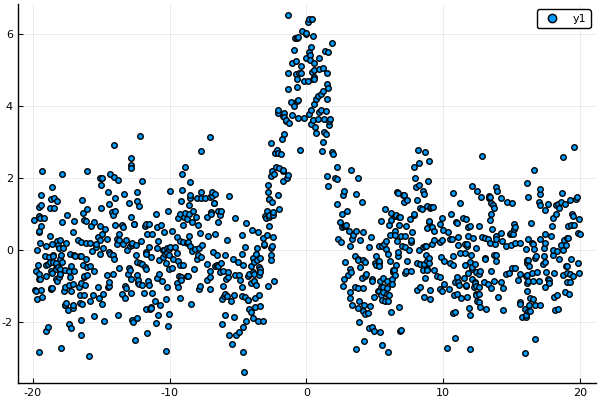

In [3]:
N = 1000
X = reshape((sort(rand(N)).-0.5).*40.0,N,1)
function latent(x)
    5.0.*sin.(x)./x
end
Y = (latent(X)+randn(N))[:];
scatter(X,Y)

In [4]:
# Run sparse classification with increasing number of inducing points
Ms = [4, 8, 16, 32, 64]
models = Vector{AbstractGP}(undef,length(Ms)+1)
kernel = RBFKernel(1.0)
for (index, num_inducing) in enumerate(Ms)
    m = SVGP(X, Y, kernel,LaplaceLikelihood(),AnalyticVI(),num_inducing)
    println("Training with $(num_inducing) points")
    @time train!(m,iterations=100)
    models[index]=m;
end

Training with 4 points
  6.069366 seconds (28.35 M allocations: 1.511 GiB, 9.99% gc time)
Training with 8 points
  0.093576 seconds (495.49 k allocations: 154.886 MiB, 19.01% gc time)
Training with 16 points
  0.151554 seconds (495.49 k allocations: 260.175 MiB, 15.77% gc time)
Training with 32 points
  0.273305 seconds (495.49 k allocations: 476.169 MiB, 14.25% gc time)
Training with 64 points
  0.542978 seconds (497.36 k allocations: 929.995 MiB, 12.66% gc time)


In [5]:
mfull = VGP(X, Y, kernel,LaplaceLikelihood(),AnalyticVI())
println("Training with full model")
@time train!(mfull,iterations=5);
models[end]=mfull;

Training with full model
  1.974235 seconds (3.53 M allocations: 636.999 MiB, 17.24% gc time)


In [6]:
function compute_Grid(model,nGrid=50)
    mins = -20
    maxs = 20
    Xplot = collect(range(mins[1],stop=maxs[1],length=nGrid))
    y = proba_y(model,Xplot)
    return (y,Xplot)
end;

In [7]:
function plotdata(X,Y)
    Plots.plot(X,Y,t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
end;

In [8]:
function plotcontour(model,X,Y)
    nGrid = 100
    (predic,x) = compute_Grid(model,nGrid);
    plotdata(X,Y)
    if in(:Z,fieldnames(typeof(model)))
        Plots.plot!(model.Z[1][:,1],zero(model.Z[1][:,1]),msize=2.0,color="black",t=:scatter,lab="")
    end
    return Plots.plot!(x,predic,title=(in(:Z,fieldnames(typeof(model))) ? "M = $(model.nFeatures)" : "full"),color="red",lab="",linewidth=3.0)
end;

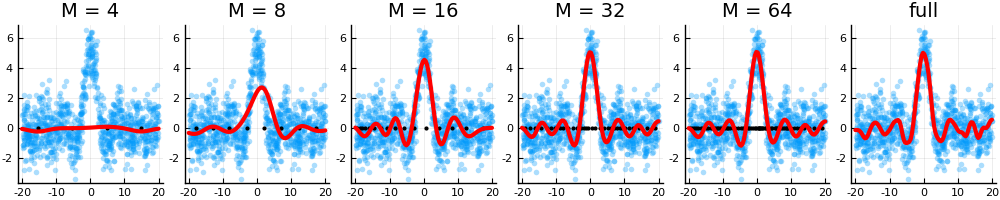

In [9]:
Plots.plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))